In [1]:
import setGPU

from functools import partial
import math

import jax
from jax import vmap
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr
import diffrax as dfx
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
import dataclasses

from check_shapes import check_shape, check_shapes
from jaxtyping import Float, jaxtyped
from typeguard import typechecked as typechecker

import neural_diffusion_processes as ndp
from neural_diffusion_processes.types import *

setGPU: Setting GPU to: 1


2023-02-06 17:15:24.430020: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-06 17:15:25.007236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-06 17:15:25.007288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-06 17:15:25.007293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
JITTER = 1e-12

In [3]:
# class MultivariateNormalDistribution:
#     @jaxtyped
#     @typechecker
#     def __init__(self, mean: Float[Array, "... nd"], scale: Float[Array, "... nd nd"], **kwargs):
#         # TODO: should we reshape mean (B, N, D) -> (B, N*D)
#         # and scale                    (B, N, N, D, D) -> (B, N*D, N*D) ?
#         self.mean = mean
#         self.scale = scale
#         # self.dist = dx.MultivariateNormalTri(mean, scale)

#     def sample(self, seed, sample_shape) -> Float[Array, "... nd"]:
#         # return jnp.expand_dims(self.dist.sample(seed=rng, sample_shape=shape), -1)
#         z = jax.random.normal(seed, (*sample_shape, *self.mean.shape))
#         bijector = lambda z: self.mean + jnp.einsum("...ij,...j->...i", self.scale, z)
#         bijector = vmap(bijector) if sample_shape != () else bijector
#         return bijector(z)

#     @jaxtyped
#     @typechecker
#     def log_prob(self, z: Float[Array, "... nd"]) -> Float[Array, "..."]:
#         shape = z.shape
#         # return self.dist.log_prob(z.reshape(-1))

#         M = jsp.linalg.solve_triangular(self.scale, z - self.mean, lower=True)
#         M = jnp.power(M, 2).sum(-1)

#         # Sigma = jnp.einsum("...ij,...kj->...ik", self.scale, self.scale)
#         # M = jnp.einsum("...j,...ij->...i", z - self.mean, jnp.linalg.inv(Sigma))
#         # M = jnp.einsum("...ij,...j->...i", M, z - self.mean)
#         # half_log_det = 0.5 * jnp.log(vmap(jnp.linalg.det)(Sigma))
#         diag = jnp.diag if len(shape) == 1 else vmap(jnp.diag)
#         half_log_det = jnp.log(diag(self.scale)).sum(-1)
#         logp = -0.5 * (shape[-1] * math.log(2 * math.pi) + M) - half_log_det
#         return logp


# @check_shapes(
#     "x: [num_points_x, dim]",
#     "y: [num_points_y, dim]",
#     "return: [num_points_x, num_points_y, *]"
#     # "return: [num_points_x, num_points_y, dim, dim] if dim > 1"
# )
# def gram(
#     kernel, x: Array, y: Optional[Array] = None
# ) -> Array:
#     y = x if y is None else y
#     return vmap(lambda x1: vmap(lambda y1: kernel(x1, y1))(y))(x)

# @check_shapes(
#     "x: [batch..., num_points, dim_x]",
# )
# def gp_prior(mean_fn, kernel, x: Array, noise=0.0):
#     # print("x", x.shape)
#     shape = x.shape
#     n_test = shape[-2]
#     μt = mean_fn(x)
#     μt = rearrange(μt, "... n d -> ... (n d)")
#     # print("μt", μt.shape)
#     gram_kernel = partial(gram, kernel)
#     Ktt = vmap(gram_kernel)(x) if len(shape) > 2 else gram_kernel(x)
#     # print("Ktt", Ktt.shape)
#     if len(Ktt.shape) > 3:
#         n_test *= Ktt.shape[-1]
#         Ktt = rearrange(Ktt, "... n m d1 d2 -> ... (n d1) (m d2)")
#         # print("Ktt", Ktt.shape)
#     # print("n_test", n_test)
#     Ktt += (JITTER + noise) * jnp.eye(n_test)
#     scale = jnp.linalg.cholesky(Ktt)
#     # dist = dx.MultivariateNormalFullCovariance(μt, Ktt)
#     # dist = dx.MultivariateNormalTri(μt, scale)
#     dist = MultivariateNormalDistribution(μt, scale)
#     return dist


# @check_shapes(
#     "x: [batch..., num_points, dim_x]",
#     "y: [batch..., num_points, dim_y]",
#     "x_eval: [batch..., num_points_eval, dim_x]",
# )
# def gp_posterior(
#     mean_fn,
#     kernel,
#     x: Array,
#     y: Array,
#     # x: f["... n x_dim"],
#     # y: Union[f["... nd"], f["... n d"]],
#     # x_eval: f["... m x_dim"],
#     x_eval: Array,
#     noise=0.0,
# ):
#     shape = x.shape
#     n = shape[-2]
#     μx = mean_fn(x)
#     μx = rearrange(μx, "... n d -> ... (n d)")
#     if y.shape[-1] == x.shape:
#         y = rearrange(y, "... n d -> ... (n d)")
#     # print("μx", μx.shape)
#     gram_kernel = partial(gram, kernel)
#     Kxx = vmap(gram_kernel)(x) if len(shape) > 2 else gram_kernel(x)
#     # print("Kxx", Kxx.shape)
#     if len(Kxx.shape) > 3:
#         n *= Kxx.shape[-1]
#         Kxx = rearrange(Kxx, "... n m d1 d2 -> ... (n d1) (m d2)")
#         # print("Kxx", Kxx.shape)
#     Kxx += (JITTER + noise) * jnp.eye(n)  # shape = [b (n d) (n d)]

#     L = jnp.linalg.cholesky(Kxx)  # shape = [b (n d) (n d)]
#     # print("L", L.shape)
#     # print("y", y.shape)
#     # print("μx", μx.shape)
#     # w = L⁻¹ (y - μx)
#     w = jsp.linalg.solve_triangular(L, y - μx, lower=True)  # shape = [b (n d)]
#     # print("w", w.shape)

#     μt = mean_fn(x_eval)  # shape = [b n d]
#     # print("μt", μt.shape)
#     μt = rearrange(μt, "... n d -> ... (n d)")  # shape = [b (n d)]
#     # print("μt", μt.shape)

#     shape = x_eval.shape
#     n_test = shape[-2]
#     Ktt = vmap(gram_kernel)(x_eval) if len(shape) > 2 else gram_kernel(x_eval)
#     # print("Ktt", Ktt.shape)
#     # Kxt = vmap(gram_kernel)(x, x_eval) if len(shape) > 2 else gram_kernel(x, x_eval)
#     if len(x.shape) <= 2 and len(x_eval.shape) <= 2:
#         Kxt = gram_kernel(x, x_eval)
#     elif len(x.shape) > 2 and len(x_eval.shape) <= 2:
#         Kxt = vmap(lambda data: gram_kernel(data, x_eval))(x)
#     elif len(x.shape) <= 2 and len(x_eval.shape) > 2:
#         Kxt = vmap(lambda data: gram_kernel(x, data))(x_eval)
#     else:
#         Kxt = vmap(gram_kernel)(x, x_eval)
#     # print("Kxt", Kxt.shape)
#     if len(Kxt.shape) > 3:
#         n_test *= Ktt.shape[-1]
#         Ktt = rearrange(Ktt, "... n m d1 d2 -> ... (n d1) (m d2)")
#         # print("Ktt", Ktt.shape)
#         Kxt = rearrange(Kxt, "... n m d1 d2 -> ... (n d1) (m d2)")
#         # print("Kxt", Kxt.shape)

#     # L⁻¹ Kxt
#     L_inv_Kxt = jsp.linalg.solve_triangular(L, Kxt, lower=True)  # shape = [b (n d) (m d)]
#     # print("L_inv_Kxt", L_inv_Kxt.shape)

#     # μt  +  Ktx (Kzz + Iσ²)⁻¹ (y  -  μx)
#     L_inv_Kxt_T = jnp.einsum("...ij->...ji", L_inv_Kxt)  # shape = [b (m d) (n d)]
#     # print("L_inv_Kxt_T", L_inv_Kxt_T.shape)

#     # mean = μt + jnp.einsum("...ji,...j->...i", L_inv_Kxt, w)
#     mean = μt + jnp.einsum("...ij,...j->...i", L_inv_Kxt_T, w)  # shape = [b (m d)]
#     # print("mean", mean.shape)

#     # Ktt  -  Ktz (Kzz + Iσ²)⁻¹ Kxt  [recall (Kzz + Iσ²)⁻¹ = (LLᵀ)⁻¹ =  L⁻ᵀL⁻¹]
#     # print(jnp.einsum("...ij,...jk->...ik", L_inv_Kxt_T, L_inv_Kxt).shape)
#     covariance = Ktt - jnp.einsum("...ij,...jk->...ik", L_inv_Kxt_T, L_inv_Kxt)
#     # print("n_test", n_test)
#     covariance += (JITTER + noise) * jnp.eye(n_test)  # shape = [b (m d) (m d)]
#     # print("covariance", covariance.shape)

#     scale = jnp.linalg.cholesky(covariance)
#     dist = MultivariateNormalDistribution(mean, scale)
#     return dist


In [17]:
beta_schedule = ndp.sde.LinearBetaSchedule()
x = jnp.linspace(-1, 1, 103)[:, None]
k0 = ndp.kernels.SquaredExpontialKernel(lengthscale=0.25)
k1 = ndp.kernels.WhiteKernel()
# k1 = ndp.kernels.SquaredExpontialKernel(lengthscale=1.0)
mean_function = lambda x: jnp.zeros_like(x)  # A zero mean function

In [18]:
def pt(x, t, y0=None):
    """Marginal of OU process at time t. When passing y0 this returns the conditional marginal."""
    # TODO: change if limiting processes have different mean functions.
    mean0 = mean1 = mean_function
    mean_coef = jnp.exp(-0.5 * beta_schedule.B(t))

    if y0 is None:
        mean = mean_coef * mean0(x) + (1.0 - mean_coef) * mean1(x)
    else:
        mean = mean_coef * y0 + (1.0 - mean_coef) * mean1(x)
    
    if y0 is None:
        cov = k1(x) + jnp.exp(-beta_schedule.B(t)) * (k0(x) - k1(x))
    else:
        cov = (1.0 -  jnp.exp(-beta_schedule.B(t))) * k1(x)
    
    return mean, cov

def sample_pt(key, x, t, y0=None):
    "Marginal distribution p(yt) if y0 is passed p(yt | xt)"
    mean, cov = pt(x, t, y0)
    chol_cov = jnp.linalg.cholesky(cov + JITTER * jnp.eye(len(mean)))
    return mean + (chol_cov @ jax.random.normal(key, (len(mean),1)))

@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
def drift(t, yt, x):
    return  - 0.5 * beta_schedule(t) * (yt - mean_function(x)) # [N, 1]
    
@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, N]",)
def diffusion(t, yt, x):
    del yt
    sqrt_K = jnp.linalg.cholesky(k1(x) + JITTER * jnp.eye(len(x)))
    return jnp.sqrt(beta_schedule(t)) * sqrt_K

solve_lower_triangular = partial(jax.scipy.linalg.solve_triangular, lower=True)  # L⁻¹ x
solve_upper_triangular = partial(jax.scipy.linalg.solve_triangular, lower=False)  # U⁻¹ x

@check_shapes("yt: [N, 1]", "x: [N, 1]", "t: []", "return: [N, 1]",)
def score(yt, x, t):
    "Exact marginal score in Gaussian setting"
    mu_t, Sigma_t = pt(x, t)
    Lt = jnp.linalg.cholesky(Sigma_t + JITTER * jnp.eye(len(Sigma_t)))
    b = yt - mu_t
    A = solve_upper_triangular(jnp.transpose(Lt), solve_lower_triangular(Lt, b))
    return - k1(x) @ A


@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
def reverse_drift_ode(t, yt, x):
    return  drift(t, yt, x) - 0.5 * beta_schedule(t) * score(yt, x, t) # [N, 1]

def reverse_drift_sde(t, yt, x):
    return  drift(t, yt, x) - beta_schedule(t) * score(yt, x, t) # [N, 1]

In [27]:
# %%
def conditional_sample(key, x_context, y_context, x_test, num_steps: int, num_inner_steps: int):
    len_context = len(x_context)
    shape_augmented_state = [len(x_test) + len(x_context), 1]  # assume 1d output

    t0 = beta_schedule.t0
    t1 = beta_schedule.t1
    ts = jnp.linspace(t1, t0, num_steps, endpoint=True)
    dt = ts[0] - ts[1]

    solver = dfx.Euler()
    # reverse ODE:
    ode_terms_reverse = dfx.ODETerm(reverse_drift_ode)

    # forward SDE:
    shape = jax.ShapeDtypeStruct(shape_augmented_state, y_context.dtype)
    key, subkey = jax.random.split(key)
    bm = dfx.VirtualBrownianTree(t0=t0, t1=t1, tol=dt, shape=shape, key=subkey)
    sde_terms_forward = dfx.MultiTerm(dfx.ODETerm(drift), dfx.ControlTerm(diffusion, bm))

    def inner_loop(key, yt, t):
        print("compiling inner_loop")
        # return yt, yt
        yt_context = sample_pt(key, x_context, t, y_context)
        yt_augmented = jnp.concatenate([yt_context, yt], axis=0)
        x_augmented = jnp.concatenate([x_context, x_test], axis=0)

        # reverse step
        yt_m_dt, *_ = solver.step(ode_terms_reverse, t, t - dt, yt_augmented, x_augmented, None, made_jump=False)
        # jax.debug.print(yt_m_dt)
        # return yt_m_dt[len_context:], yt_m_dt[len_context:]

        # forward step
        yt, *_ = solver.step(sde_terms_forward, t - dt, t, yt_m_dt, x_augmented, None, made_jump=False)
        # strip context from augmented state
        return yt[len_context:], yt_m_dt[len_context:]

    def outer_loop(key, yt, t):
        print("compiling outer_loop")
        _, yt_m_dt = jax.lax.scan(lambda yt, key: inner_loop(key, yt, t), yt, jax.random.split(key, num_inner_steps))
        yt = yt_m_dt[-1]
        return yt, yt


    key, subkey = jax.random.split(key)
    yT = sample_pt(subkey, x_test, 1.0)

    xs = (ts[:-1], jax.random.split(key, len(ts) - 1))
    y0, _ = jax.lax.scan(lambda yt, x: outer_loop(x[1], yt, x[0]), yT, xs)
    return y0

compiling outer_loop
compiling inner_loop


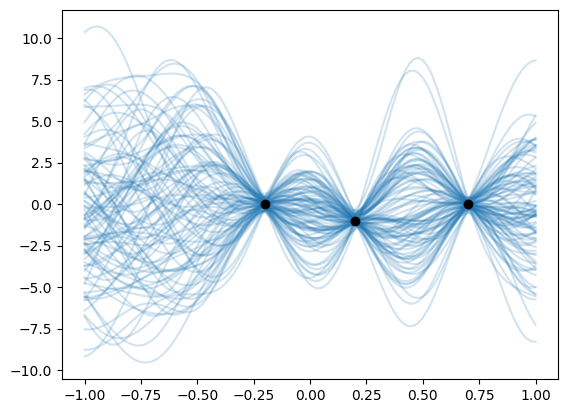

In [28]:
x_known = jnp.reshape(jnp.asarray([[-0.2, 0.2, 0.7]]), (-1, 1))
y_known = jnp.reshape(jnp.asarray([[0.0, -1.0, 0.0]]), (-1, 1))
x_test = jnp.linspace(-1, 1, 101)[:, None]
key = jax.random.PRNGKey(0)
samples = jax.vmap(lambda key: conditional_sample(key, x_known, y_known, x_test, 100, 10))(jax.random.split(key, 100))

# %%
plt.figure()
plt.plot(x_test, samples[..., 0].T, "C0", alpha=.2)
plt.plot(x_known, y_known, "ko")
plt.show()

In [54]:
from chex import assert_trees_all_close

# shift x values
shift = 1

t = jnp.array(0.5)

assert_trees_all_close(drift(t, y_known, x_known), drift(t, y_known, x_known + shift))

assert_trees_all_close(score(y_known, x_known, t), score(y_known, x_known + shift, t))

assert_trees_all_close(reverse_drift_ode(t, y_known, x_known), reverse_drift_ode(t, y_known, x_known + shift))

: 

compiling outer_loop
compiling inner_loop


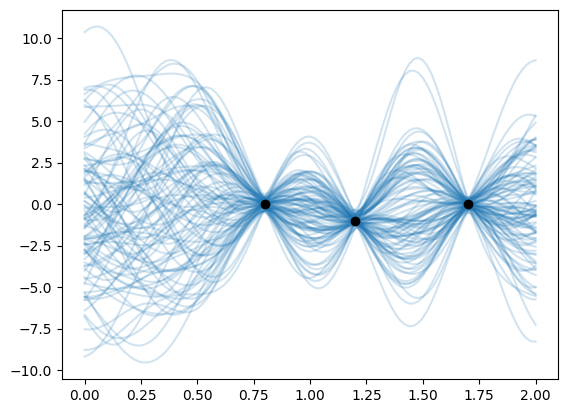

In [50]:
# check that p(g.y^*|g.x^*,g.x,g.y) = p(y^*|g.x^*,g.x,y) = p(y^*|x^*-g ,x-g,y) = p(y^*|x^*,x,y) for 1D setting

x_test = jnp.linspace(-1 + shift, 1 + shift, 101)[:, None]
samples = jax.vmap(lambda key: conditional_sample(key, x_known + shift, y_known, x_test, 100, 10))(jax.random.split(key, 100))
# %%
plt.figure()
plt.plot(x_test, samples[..., 0].T, "C0", alpha=.2)
plt.plot(x_known + shift, y_known, "ko")
plt.show()

In [36]:
y_known

Array([[ 0.],
       [-1.],
       [ 0.]], dtype=float64)